In [1]:
import argparse
from statistics import mean, stdev
from time import perf_counter

import torch
from torch.nn.functional import linear

from graphesn import DynamicGraphReservoir, initializer, Readout
from graphesn.util import compute_dynamic_graph_alpha, compute_dynamic_weighted_graph_alpha
from stocks_loader import *


def prepare_stocks_data(device, weighted=False, lags=1):
    data = stocks_dataset(feature_mode=None, target_offset=lags).to(device)
    alpha = compute_dynamic_weighted_graph_alpha(data) if weighted else compute_dynamic_graph_alpha(data)
    
    return data.edge_index, data.edge_weight if weighted else None, data.x, data.y, alpha, data.num_timesteps

In [2]:
def to_pc(x):
    return (x[1:] - x[0:-1])/x[0:-1]

In [3]:
def all_pc(edge_index, edge_weight, x, y, alpha, T):
    x = to_pc(x)
    edge_index = edge_index[1:]
    # edge_weight = edge_weight[1:]
    y = to_pc(y)
    T = T-1

    return edge_index, edge_weight, x, y, alpha, T

In [4]:
args_dict = {
    'units': 32,
    'device' : 'cuda',
    'sigma' : 0.9,
    'leakage' : 0.9,
    'ld' : [1e-3],
    'trials' : 20    
}

device = torch.device(args_dict['device'])
edge_index, edge_weight, x, y, alpha, T = prepare_stocks_data(device=device)
# edge_index, edge_weight, x, y, alpha, T = all_pc(edge_index, edge_weight, x, y, alpha, T)


In [5]:

T_train, T_valid = int(T * 0.8), int(T * 0.9)
print(f'alpha = {alpha:.2f}')

train_time, train_mse, test_time, test_mse = [], [], [], []


def validate_on(weights, Xval, yval):
    return torch.mean((linear(Xval, weights[0], weights[1]) - yval) ** 2)

for _ in range(args_dict['trials']):
    reservoir = DynamicGraphReservoir(num_layers=1, in_features=x.shape[-1], hidden_features=args_dict['units'], return_sequences=True)
    reservoir.initialize_parameters(recurrent=initializer('uniform', sigma=args_dict['sigma'] / alpha),
                                    input=initializer('uniform', scale=1),
                                    leakage=args_dict['leakage'])
    reservoir.to(device)
    readout = Readout(num_features=args_dict['units'], num_targets=10)

    tic = perf_counter()
    
    X = reservoir(edge_index=edge_index[:T_valid] if isinstance(edge_index, list) else edge_index, input=x[:T_valid])
    readout.fit(data=(X[:T_train].view(-1, X.shape[-1]), y[:T_train].view(-1, y.shape[-1])), regularization=args_dict['ld'],
                validate=lambda weights: validate_on(weights, X[T_train:T_valid].view(-1, X.shape[-1]), y[T_train:T_valid].view(-1, y.shape[-1])))
    
    toc = perf_counter()
    
    y_hat_train = readout(X[:T_train].view(-1, X.shape[-1]))
    mse_loss = torch.mean(( y_hat_train - y[:T_train].view(-1, y.shape[-1])) ** 2)
    train_mse.append(mse_loss.item())
    train_time.append((toc - tic) * 1000)

    tic = perf_counter()
    
    X = reservoir(edge_index=edge_index, input=x)
    y_hat = readout(X[T_valid:].view(-1, X.shape[-1]))
    
    mse_loss = torch.mean((y_hat - y[T_valid:].view(-1, y.shape[-1])) ** 2)
    toc = perf_counter()
    
    test_mse.append(mse_loss.item())
    test_time.append((toc - tic) * 1000)


alpha = 3.88


In [6]:
print(f'{mean(train_mse):.3f} ± {stdev(train_mse):.3f}',
      f'{mean(test_mse):.3f} ± {stdev(test_mse):.3f}',
      f'{mean(train_time):.5f} ± {stdev(train_time):.5f}',
      f'{mean(test_time):.5f} ± {stdev(test_time):.5f}',
      sep='\t')

0.056 ± 0.041	0.520 ± 0.489	13.84642 ± 1.62104	14.42279 ± 0.56192


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

Text(0, 0.5, 'MSE loss')

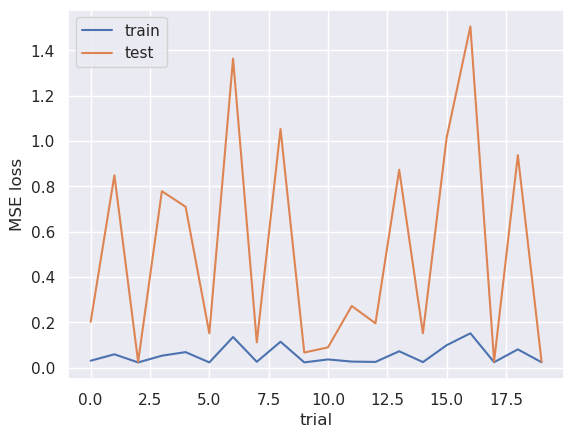

In [8]:
plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.legend()
plt.xlabel('trial')
plt.ylabel('MSE loss')

Text(0.5, 1.0, 'Training')

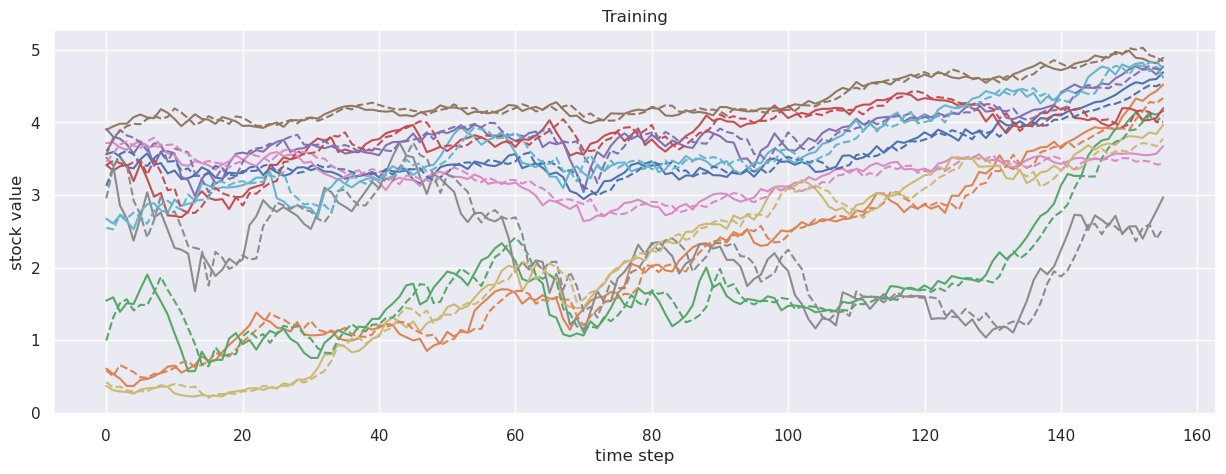

In [9]:
# Train
s = y[:T_train].shape[0]

Y_PRED = y_hat_train.reshape((s,10))
Y_TARGET = y[:T_train].reshape((s,10))

plt.figure(figsize=(15,5))
plt.plot(Y_TARGET.detach().cpu(), label='target')
plt.plot(Y_PRED.detach().cpu(), '--', label='forecast')
plt.xlabel('time step')
plt.ylabel('stock value')
plt.title('Training')


Text(0.5, 1.0, 'Testing')

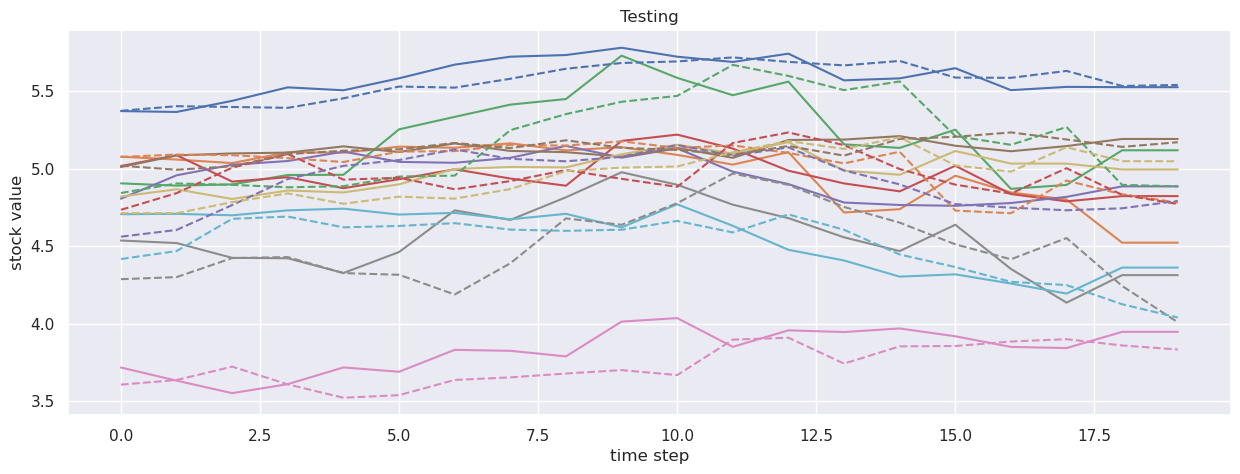

In [10]:
# Test
s = y[T_valid:].shape[0]

Y_PRED = y_hat.reshape((s,10))
Y_TARGET = y[T_valid:].reshape((s,10))

plt.figure(figsize=(15,5))
plt.plot(Y_TARGET.detach().cpu(), label='target')
plt.plot(Y_PRED.detach().cpu(), '--', label='forecast')
plt.xlabel('time step')
plt.ylabel('stock value')
plt.title('Testing')


In [157]:
file_path = './results/dyngesn_dict.pkl'

# Loading dataset from pickle
with open(file_path, 'rb') as f:
    dict_ = pickle.load(f)           

In [165]:
L_train = len(dict_["y_in_train"][0])
L_test = len(dict_["y_in_test"][0])

In [166]:
L_train, L_test

(1560, 200)

In [167]:
n_nodes = 10

y_out_test = np.array(dict_["y_out_test"][0].detach().cpu()) 

y_in_train = np.array(dict_["y_in_train"]).T.reshape(L_train//n_nodes, n_nodes).T
y_out_train = np.array(dict_["y_out_train"]).T.reshape(L_train//n_nodes, n_nodes).T

y_in_test = np.array(dict_["y_in_test"]).reshape(L_test//n_nodes, n_nodes).T
y_out_test = y_out_test.reshape(L_test//n_nodes, n_nodes).T


In [168]:
y_in_test.shape

(10, 20)

Text(0, 0.5, 'stock value')

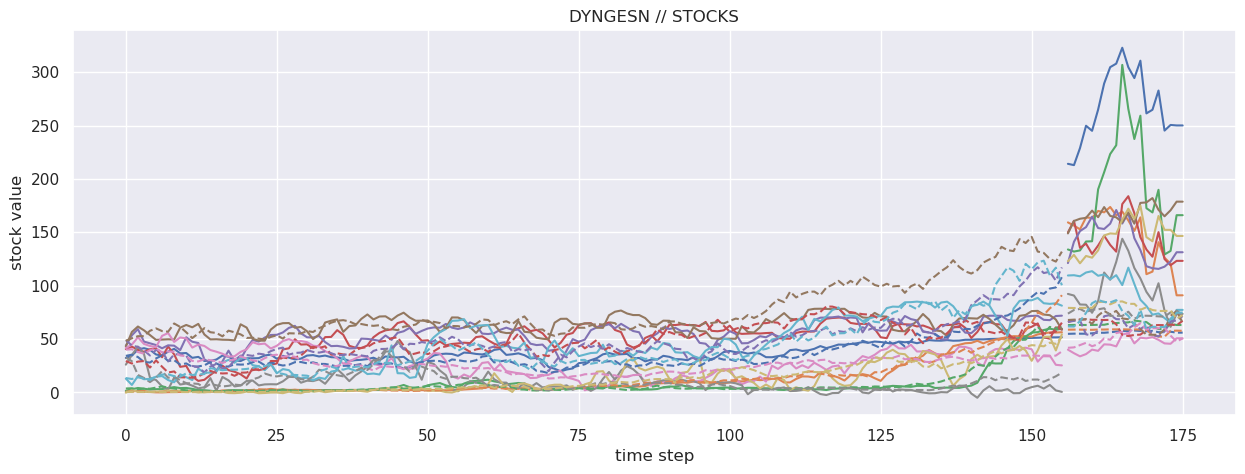

In [187]:

L_train = y_in_train.shape[1]
L_test = y_in_test.shape[1]

t_train = np.arange(0,L_train)
# t_valid = np.arange( L_train, L_train + L_valid )
t_test = np.arange( L_train, L_train + L_test )

plt.figure(figsize=(15,5))
# plt.plot(t_train, y_in_train)
# plt.plot(t_train, y_out_train, '--')

# plt.plot(t_valid, np.array(dict_["y_in_valid"]).reshape(L_valid,10))
# plt.plot(t_valid, np.array(dict_["y_out_valid"]).reshape(L_valid,10), '--')

for i in range(n_nodes):
    plt.plot(t_train, y_in_train[i])
for i in range(n_nodes):
    plt.plot(t_train, y_out_train[i], '--')


for i in range(n_nodes):
    plt.plot(t_test, y_in_test[i])
for i in range(n_nodes):
    plt.plot(t_test, y_out_test[i], '--')
    

plt.title('DYNGESN // STOCKS')

plt.xlabel('time step')
plt.ylabel('stock value')
# plt.xlim([1600,1700])

(0, 20)

### ARIMA

In [1]:
import numpy as np 
import pickle
import pandas as pd 



In [2]:
X.shape

(207, 10)

In [3]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

def fn_arima(data, n, step_size):
    # Perform the rolling forecast
    data_forecast = []

    for i in range(n, len(data), step_size):
        
        # update input data
        input_data = data[max(0,i-n):i]
        
        # learn
        model = ARIMA(input_data, order=(2,1,2))
        model_fit = model.fit()
        
        # forecast
        f = model_fit.forecast(steps=step_size)
        data_forecast.append(f)
        
    return np.array(data_forecast).flatten()


In [4]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()

y = X.T[1]
n_back = 50
n_ahead = 10
y_pred = fn_arima(y, n_back, n_ahead)

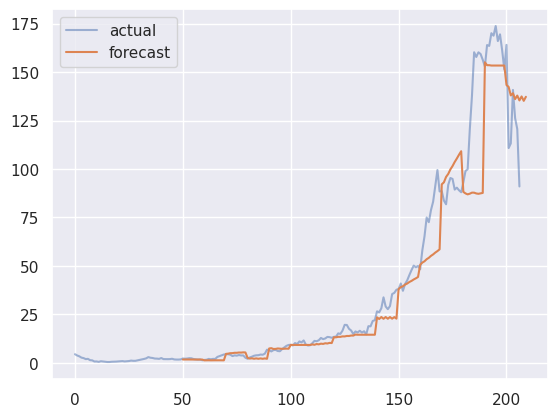

In [347]:
plt.plot(y, label='actual', alpha=0.5)
plt.plot( np.arange(n_back, n_back+ len(y_pred) ), y_pred, label='forecast')
plt.legend()

In [5]:
from graphesn.dataset import chickenpox_dataset, twitter_tennis_dataset, pedalme_dataset, wiki_maths_dataset
from stocks_loader import *

dataset_dict = {"chickenpox": chickenpox_dataset(target_lags=1),
                "tennis": twitter_tennis_dataset(feature_mode='encoded', target_offset=1),
                "pedalme": pedalme_dataset(target_lags=1),
                "wikimath": wiki_maths_dataset(target_lags=1)       
                }

In [6]:
for dataset_name in dataset_dict.keys():
    data = dataset_dict[dataset_name]
    print(dataset_name, data)

chickenpox TemporalData(x=[520, 20, 1], edge_index=[2, 102], y=[520, 20, 1])
tennis DynamicData(edge_index, edge_weight, x, y)
pedalme TemporalData(x=[34, 15, 1], edge_index=[2, 225], y=[34, 15, 1], edge_weight=[225])
wikimath TemporalData(x=[730, 1068, 1], edge_index=[2, 27079], y=[730, 1068, 1], edge_weight=[27079])


In [7]:
def arima_on_dataset(dataset):
    data = dataset_dict[dataset]
    mse_list = []
    for m in range(len(data.y[0])):
        try:
            y = np.array(data.y.T[0][m].detach().cpu())
            n_back = 50
            n_ahead = 1
            y_pred = fn_arima(y, n_back, n_ahead)
            mse = np.mean( np.square( y[n_back: n_back+ len(y_pred) ] - y_pred ) )
            print(mse)
            mse_list.append(mse)
        except:
            pass
            
    print(dataset, np.mean(mse))

In [19]:
dataset_name = "chickenpox"
data = dataset_dict[dataset_name]
n_back = 50
mse_list = []
for m in range(len(data.y[0])):
    y_in =  np.array(data.y.T[0][m])
    try:
        y_pred = fn_arima(y_in, n_back, 1)
        mse = np.mean( np.square( y_in[n_back: n_back+ len(y_pred) ] - y_pred ) )
        mse_list.append(mse)
    except:
        print(np.mean(mse_list))
     
print(np.mean(mse_list))

KeyError: 'stocks'

In [17]:
mse_list

[0.8448637887763936,
 0.9549581133466393,
 0.8698731959757704,
 0.8747695697270085,
 1.0006376571625077,
 1.0904795075064941,
 0.7977202811949125,
 0.8081980561194618,
 1.0369936947666218,
 0.8147567953910758,
 0.8675622644198989,
 0.7227480235824129,
 0.6900578609016845,
 1.034144962766669]

In [18]:
len(mse_list), np.mean(mse_list)

(14, 0.8862688408312538)

In [383]:
for dataset_name in dataset_dict.keys():
    arima_on_dataset(dataset_name)

0.8448637887763936
0.9549581133466393
0.8698731959757704
0.8747695697270085
1.0006376571625077
1.0904795075064941
0.7977202811949125
0.8081980561194618
1.0369936947666218
0.8147567953910758
0.8675622644198989
0.7227480235824129
0.6900578609016845
1.034144962766669
chickenpox 1.034144962766669
0.17609048618865722
0.7433327493225609
0.8924296796615544
1.1432949907567271
0.4659549299335089
1.0837370667142567
0.9790407805041795
1.1639709996841996
1.3502423476680938
0.6232110743266942
1.0359860372169412
0.6659270715681537
1.2349892545086267
0.869401015768603
0.9778146511588852
0.7931214489513854
0.8849044226448856
0.4106831754339438
0.6935353627471331
1.1308919539178544
0.9897075753930699
1.1458035926517292
0.2407723565683488
0.540905103597211
0.6695836106706781
0.9300862956478498
0.08820863751647479
0.0
1.272502848742169
1.209337484235503
0.09380732518862184
0.9569768780410156
1.373385858449387
0.11893904698172726
0.6893281078777502
1.3120455440549716
1.3327716018888993
1.201463014871189
0

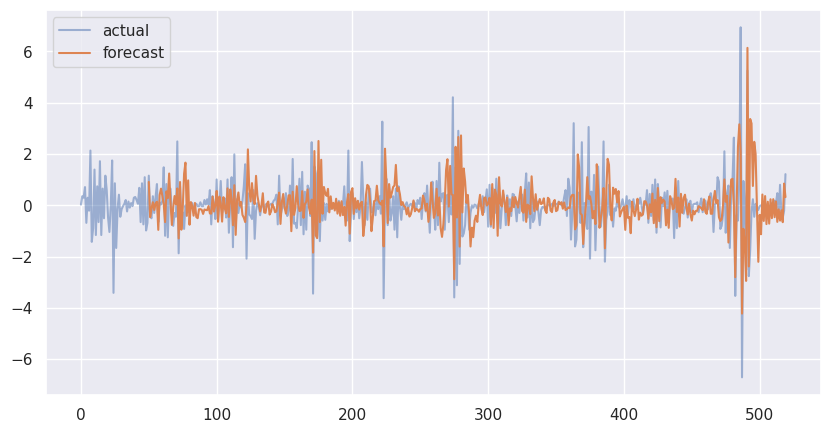

In [327]:
plt.figure(figsize=(10,5))
plt.plot(y, label='actual', alpha=0.5)
plt.plot( np.arange(n_back, n_back+ len(y_pred) ), y_pred, label='forecast')
plt.legend()

0.9030510920167591